# Dataset



In [1]:
import os

DATA_DIR = "/home/kdang/projects/spartDM/data/starmen/output_random_noacc"
os.chdir("/home/kdang/projects/spartDM/")
print("Current working directory:", os.getcwd())

Current working directory: /home/kdang/projects/spartDM


In [ ]:
import numpy as np
from torch.utils.data import DataLoader

from src.data import StarmenDataset

starmen = StarmenDataset(DATA_DIR, split="train", nb_subject=5)
print(starmen.datas.shape)
train_loader = DataLoader(starmen, batch_size=2)

# x, x_prev = next(iter(train_loader))



(50, 5)


In [ ]:
import numpy as np

from src.sadm.vivit import ViViT

vivit = ViViT(
    image_size = (64, 64),
    patch_size = (16, 16),
    num_frames = 9,
    depth = 3,
    heads = 3,
    dim_head=8
)

In [ ]:
import torch
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import nn

patch_size = (16, 16) 
p1, p2 = patch_size
h, w = (4, 4)
patch_dim = int(np.prod(patch_size))


# c = vivit(x_prev)




temporal_layer = vivit.temporal_transformer.layers
len(temporal_layer)
vivit.temporal_dims


x_prev.shape
x = vivit.to_patch_embedding(x_prev)
b, t, n, d = x.shape
x += vivit.pos_embedding
x = vivit.dropout(x)
x = rearrange(x, "b t n d -> b (t n) d")
x = vivit.temporal_transformer(x)

print(f"After temporal transformer x.shape: {x.shape}")

# Perform space transformer

space_layer = vivit.space_transformer.layers
len(space_layer)


# vivit.space_dims
x = rearrange(x, "b (t n) d -> b d (t n)", b=2, t=9, n=16)
print(x.shape)

space_layer[0]

After temporal transformer x.shape: torch.Size([2, 144, 1])
torch.Size([2, 1, 144])


ModuleList(
  (0): PreNorm(
    (norm): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (fn): Attention(
      (to_qkv): Linear(in_features=144, out_features=72, bias=False)
      (to_out): Sequential(
        (0): Linear(in_features=24, out_features=144, bias=True)
        (1): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (1): PreNorm(
    (norm): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (fn): FeedForward(
      (net): Sequential(
        (0): Linear(in_features=144, out_features=144, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (2): Upsample(
    (net): Sequential(
      (0): Upsample(scale_factor=4.0, mode='nearest')
      (1): Rearrange('b t (u d) -> b (u t) d', d=144)
    )
  )
)

In [6]:
vivit.temporal_transformer.layers[0]

vivit.space_dims

x_ups = vivit.space_transformer(x)
print(x_ups.shape)

# Conv2D last layers
conv = vivit.conv
x1 = conv[0](x_ups)
print(f"x upsample Conv2d shape: {x1.shape}")
x2 = conv[1](x1)
print(f"Rearrange shape: {x2.shape}")
conv[-1]
x3 = conv[-1](x2)
print(f"Output x: {x3.shape} (b c H W)")

torch.Size([2, 256, 144])
x upsample Conv2d shape: torch.Size([2, 256, 2304])
Rearrange shape: torch.Size([2, 144, 64, 64])
Output x: torch.Size([2, 1, 64, 64]) (b c H W)


## Visualize output

(27, 2, 1, 64, 64)


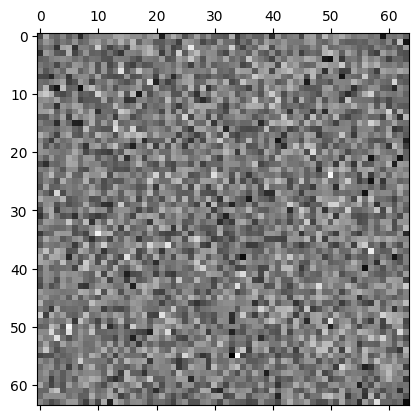

In [9]:
import numpy as np
import matplotlib.pyplot as plt


output_dir = "outdirs/x_gen_0.npy"
x_gen0 = np.load(output_dir)
x_gen0.shape

x_gen_store = np.load("outdirs/x_gen_store_0.npy")
print(x_gen_store.shape)

img = x_gen_store[0][0].squeeze()
plt.matshow(img, cmap="gray")